<a href="https://colab.research.google.com/github/tayfunai/CNN-IMAGE-CLASSIFICATION-MODELS/blob/main/GoogleNet_FineTune_Pre_Trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FineTune pre-trained GoogleNet model on Intel Image Classification dataset :



### 0. Steps to download Kaggle datasets in Google Colab
1.   Go to kaggle account *Profile>Settings>API* **Expire Token** and then **Create New Token** and it will download ***kaggle.json*** fie on your machine.
2.   Go to your google colab project file and run folowing commands:
  *   Install kaggle API client `!pip install -q kaggle`
  *   Upload the kaggle.json file here
  *   Kaggle API client expects the file to be in ~/.kaggle so move it there
  *   `!mkdir -p ~/.kaggle`
  *   `!mv kaggle.json ~/.kaggle`
  *   `!chmod 600 ~/.kaggle/kaggle.json`











### 1. Download NCT-CRC-HE-100K dataset from kaggle



In [ ]:
!pip install -q kaggle

In [ ]:
# Upload the kaggle.json file here
# Following command fill prompt you to upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tayfun777","key":"dec8ab5d4a7c37cd4891cf318e8e951b"}'}

In [ ]:
# Kaggle API client expects the file to be in ~/.kaggle so move it there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list


ref                                                          title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance         Student Habits vs Academic Performance                  19512  2025-04-12 10:49:08.663000          17369        300  1.0              
umeradnaan/daily-social-media-active-users                   Daily Social Media Active Users                        126814  2025-05-05 02:11:50.873000           1236         21  1.0              
fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid      Heart Attack Dataset                                    16250  2025-04-30 21:58:22.740000           2988         52  1.0              
khushikyad001/impact

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification -p /content --force

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 336M/346M [00:01<00:00, 201MB/s]
100% 346M/346M [00:01<00:00, 211MB/s]


In [ ]:
from zipfile import ZipFile
with ZipFile("/content/intel-image-classification.zip") as file:
  file.extractall("/content")

In [ ]:
!mkdir -p /content/data

In [ ]:
!mv /content/seg_pred/seg_pred /content/data/

In [ ]:
!mv /content/seg_train/seg_train /content/data

In [ ]:
!mv /content/seg_test/seg_test /content/data

In [ ]:
!rmdir /content/seg_test

In [ ]:
!rmdir /content/seg_pred

In [ ]:
!rmdir /content/seg_train

In [ ]:
!rm -rf /content/intel-image-classification.zip

In [ ]:
train_dir = "/content/data/seg_train"
test_dir = "/content/data/seg_test"
pred_dir = "/content/data/seg_pred"

### 1. Imports

In [ ]:
!pip install tqdm

In [ ]:
import os
import time

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image

from typing import Tuple, Dict, List
import pathlib

from tqdm.auto import tqdm
from timeit import default_timer as timer

In [ ]:
## SETTINGS ##
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameter
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Architecture
NUM_CLASSES = 6
IN_CHANNELS = 3

# Other
RANDOM_SEED = 42

### 2. Exploring dataset for all images

In [ ]:
import os
def walkt_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(dirpath)
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

In [ ]:
walkt_through_dir("/content/data")

/content/data
There are 3 directories and 0 images in '/content/data
/content/data/seg_pred
There are 0 directories and 7301 images in '/content/data/seg_pred
/content/data/seg_test
There are 6 directories and 0 images in '/content/data/seg_test
/content/data/seg_test/buildings
There are 0 directories and 437 images in '/content/data/seg_test/buildings
/content/data/seg_test/mountain
There are 0 directories and 525 images in '/content/data/seg_test/mountain
/content/data/seg_test/sea
There are 0 directories and 510 images in '/content/data/seg_test/sea
/content/data/seg_test/street
There are 0 directories and 501 images in '/content/data/seg_test/street
/content/data/seg_test/forest
There are 0 directories and 474 images in '/content/data/seg_test/forest
/content/data/seg_test/glacier
There are 0 directories and 553 images in '/content/data/seg_test/glacier
/content/data/seg_train
There are 6 directories and 0 images in '/content/data/seg_train
/content/data/seg_train/buildings
There a

### 3. Create a Custom Dataset to replicate ImageFolder

In [ ]:

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the class names in a target directory
      by scanning through target directory"""

  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
# Write a custom dataset

# 1. Subclass a torch.tuils.data.Dataset
class ImageFolder(Dataset):

  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image path

    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transform
    self.transform = transform

    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens and transforms an image into a PyTorch image"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # 6. Overwrite __get_item() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
find_classes(train_dir)

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
 {'buildings': 0,
  'forest': 1,
  'glacier': 2,
  'mountain': 3,
  'sea': 4,
  'street': 5})

In [ ]:
# Create a transform

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Test out ImageFolder

train_data = ImageFolder(
    train_dir,
    transform=train_transform
)

test_data = ImageFolder(
    test_dir,
    transform=test_transform
)


In [ ]:
len(train_data), len(test_data)

(14034, 3000)

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [ ]:
for batch_idx, (img, label) in enumerate(train_loader):
  print(f"Image shape: {img.shape}")
  print(f"Label shape: {label.shape}")
  break

for batch_idx, (img, label) in enumerate(test_loader):
  print(f"Image shape: {img.shape}")
  print(f"Label shape: {label.shape}")
  break

Image shape: torch.Size([128, 3, 224, 224])
Label shape: torch.Size([128])
Image shape: torch.Size([128, 3, 224, 224])
Label shape: torch.Size([128])


#### 3.1 Show sample images

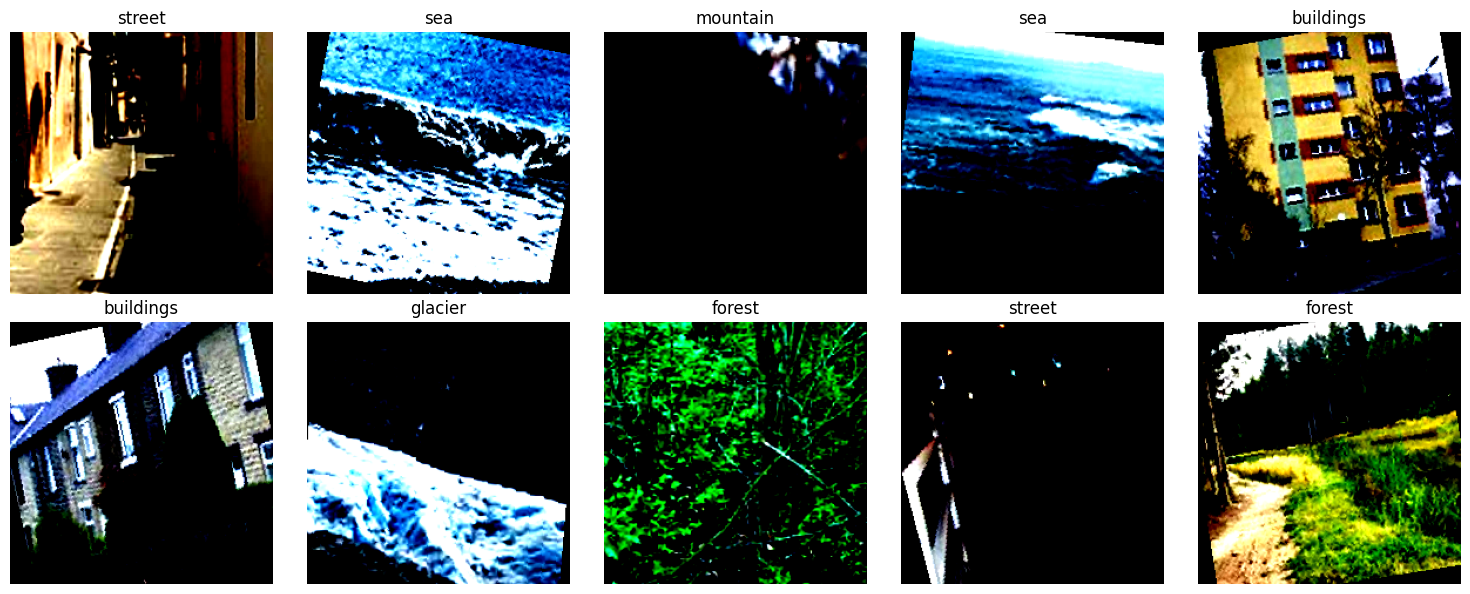

In [ ]:
images, labels = next(iter(train_loader))
images_10 = images[:10]
labels_10 = labels[:10]

class_names = train_data.classes

# Plot 10 images
plt.figure(figsize=(15, 6))
for i in range(10):
  img = images_10[i].permute(1, 2, 0).numpy()
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(class_names[labels_10[i]])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### 4. Transfer learning from pre trained GoogleNet

In [ ]:
model = models.googlenet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze eearly layers

for layer in model.modules():
  if not isinstance(layer, nn.Linear):
    layer.requires_grad_(False)
  else:
    print(layer)

Linear(in_features=1024, out_features=1000, bias=True)


In [ ]:
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

In [ ]:
model.fc

Linear(in_features=1024, out_features=6, bias=True)

In [ ]:
# Setup loss function and optimizer
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Set random seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

#### 4.1 Create train and test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in train mode
  model.train()
  model = model.to(device)

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2.Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero_grad()
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics accross all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get avarage loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module):
  # Put model in eval mode
  model.eval()
  model.to(device)

  # Set up test loss an test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # 3. Calculate the accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get avarage loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [ ]:
# Create a train() by combining train_step() and test_step()
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int):

  # 1. Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # 2. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    # 4. Print out what's happening
    print(f"Epoch: {epoch+1} | "
    f"train_loss: {train_loss:.4f} | "
    f"train_acc: {train_acc:.4f} | "
    f"test_loss: {test_loss:.4f} | "
    f"test_acc: {test_acc:.4f}")

    # 5. Update results dictionary
    # We have to make sure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)

  # 6. Return filled results at the end of the epoch
  return results


In [ ]:
# Start the timer
start_time = timer()

# Train model
model_results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0068 | train_acc: 0.6845 | test_loss: 0.5654 | test_acc: 0.8521
Epoch: 2 | train_loss: 0.6365 | train_acc: 0.7860 | test_loss: 0.4429 | test_acc: 0.8698
Epoch: 3 | train_loss: 0.5787 | train_acc: 0.7955 | test_loss: 0.4183 | test_acc: 0.8646
Epoch: 4 | train_loss: 0.5483 | train_acc: 0.8026 | test_loss: 0.3853 | test_acc: 0.8755
Epoch: 5 | train_loss: 0.5388 | train_acc: 0.8036 | test_loss: 0.3658 | test_acc: 0.8792
Epoch: 6 | train_loss: 0.5213 | train_acc: 0.8111 | test_loss: 0.3578 | test_acc: 0.8843
Epoch: 7 | train_loss: 0.5198 | train_acc: 0.8111 | test_loss: 0.3517 | test_acc: 0.8828
Epoch: 8 | train_loss: 0.5124 | train_acc: 0.8132 | test_loss: 0.3513 | test_acc: 0.8776
Epoch: 9 | train_loss: 0.5163 | train_acc: 0.8061 | test_loss: 0.3499 | test_acc: 0.8810
Epoch: 10 | train_loss: 0.5103 | train_acc: 0.8141 | test_loss: 0.3330 | test_acc: 0.8834
Total training time: 604.905 seconds.
